# INF 264 - Project 2: Digit recognizer

## Introduction

In this project we will be using different classifiers to classify handwritten digits from the MNIST handwritten digits database. We will be evaluating the different classifiers by testing how well they perform on unseen data and selecting the best model based on the performance on validation data. Finally we will see how well the best model generalizes by seeing how well it performs on testing data.

In [84]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, recall_score, precision_score ,accuracy_score, confusion_matrix

## Loading in and exploring the data

In this section we will load in the datas and explore it a bit. We want to see how the data is structured, what the value ranges are, the label distribution as well as if there are any null values or duplicate values in the data.

In [85]:
#read in MNIST-images.npy and MNIST-labels.npy
images = np.load('MNIST-images.npy')
labels = np.load('MNIST-labels.npy')

#First lets print the shape of the images and labels
print("Shape of images: ", images.shape)
print("Shape of labels: ", labels.shape)

Shape of images:  (85273, 24, 24, 1)
Shape of labels:  (85273,)


We can see that there are a total of 85273 images and labels where each image is a 24x24 array. Next let's look at the value range

In [86]:
#Lets see what the range of values are
print("Range of values in images: ", np.min(images), "to", np.max(images))
print("Range of values in labels: ", np.min(labels), "to", np.max(labels))

Range of values in images:  0 to 255
Range of values in labels:  0 to 10


We can see that the values range from 0 to 10 where 10 means "not a number". Each image has a value from 0 to 255. These are greyscalevalues where 0 means white and 255 means black.

In [87]:
#Let's see if there are any null values in the dataset
print("Dataset contains null values: ", np.any(np.isnan(images)))

Dataset contains null values:  False


It looks like our dataset is complete, which means we don't have to account for null values by imputing values.

In [88]:
#See how many duplicate images there are
print("Number of duplicate images: ", len(images) - len(np.unique(images, axis=0)))

Number of duplicate images:  0


It also seems that all the images are unique. Next we will have a look at the fist few images. 

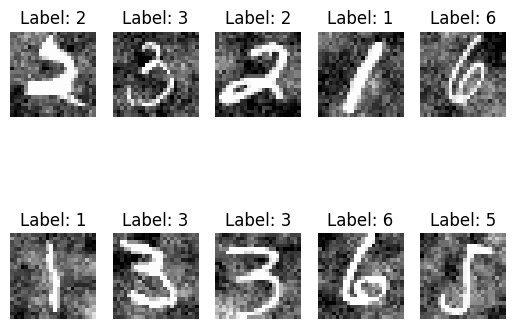

In [89]:
#Plot the first 10 images
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title('Label: {}'.format(labels[i]))
    plt.axis('off')

It is worth noting that there is quite a bit of noice in the background. Later we can try to reduce the noise with some image pre-processing and see if our models improve, but for now we can leave it as is.

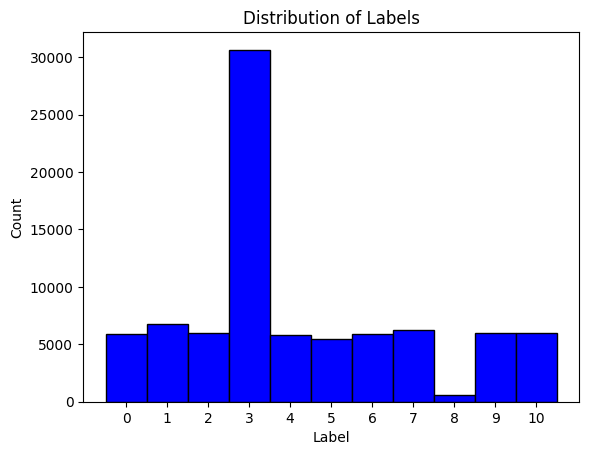

Label 0: 5923 (6.95%)
Label 1: 6742 (7.91%)
Label 2: 5958 (6.99%)
Label 3: 30655 (35.95%)
Label 4: 5842 (6.85%)
Label 5: 5421 (6.36%)
Label 6: 5918 (6.94%)
Label 7: 6265 (7.35%)
Label 8: 600 (0.70%)
Label 9: 5949 (6.98%)
Label 10: 6000 (7.04%)


In [90]:
#Next lets look at the distribution of labels in the dataset

#Function to plot the distribution of labels and printing the number of each label
def plot_distribution(labels):
    #Plots the histogram
    plt.hist(labels, bins=np.arange(12)-0.5, color='blue', edgecolor='black')
    plt.xticks(np.arange(0, 11, 1))
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Labels')
    plt.show()

    #List to store the label counts
    label_counts = []

    #Calculate the label count for each label
    for i in range(11):
        label_count = np.sum(labels == i)
        label_counts.append(label_count)

    #Print the label counts as well as the percentage of the total
    for i in range(11):
        print("Label {}: {} ({:.2f}%)".format(i, label_counts[i], label_counts[i]/len(labels)*100))

plot_distribution(labels)

We can see that there is an imbalance in the dataset. There are way more images of three's than the rest of the numbers. Also we can see that there are very few eight's in the dataset. This imbaleance is something we need to take into account when choosing which metric to use for evaluating model performance. For example is accuracy score generally a poor metric for evaluating model performance on imbalanced data because it means our models could favor predicting the majority labels. In the extreme case if the data is really unbalanced we can simply predict the majority label every time and get a pretty good accuracy score. We could choose another metric like recall, precision or a combination like the F1 score, but this is generally used when the positive class is more important to predict than the negative class. In our case it is equally important to classify all the labels correctly so I will instead try to deal with the imbalance in another way.

One method we can use to deal with the issue of the imbalance is to use resampling techniques. For example we could randomly remove about 24,000 three's to try and balance the data. This is called under-sampling. One disadvantage of this is that we lose a lot of our training data which may reduce the performance of a selected model. Also the small sample of three's selected may not represent the entire population of three's.

Similarily we can use over-sampling for the eight's by randomly duplicating or generate new eight's by using synthetic minority oversampling technique (SMOTE). The problem with this is that this can increase the chance of overfitting.

Later in the report after we have split the data into training, validation and testing we will try out these techniques on the training data.


Another thing we need to take into consideration is which classifiers to use on imbalanced datasets. Decision trees are known to perform well on imbalanced data, in particular ensembles like Random Forest Classifier. Therefore one of the classifiers we will use is the Random Forest Classifier.

### Data preprocessing/feature engineering

#TODO: explain why we use one hot encoding and why it is useful

In [91]:
#One-hot encode the labels
one_hot_labels = pd.get_dummies(labels).to_numpy()

#Print the first 5 rows of the one-hot encoded labels to see if it worked
print("Labels before one-hot encoding: ", labels[0:5])
print("Labels after one-hot encoding: ")
print(one_hot_labels[0:5])

Labels before one-hot encoding:  [2 3 2 1 6]
Labels after one-hot encoding: 
[[0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]]


We can see that the one-hot encoding worked

## Splitting the data

In [92]:
#Splitting the data into training, validation and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(images, labels, test_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

Here we have used 70% of the data as training data, 15% for validation and 15% for testing. Lets have a quick look at the distribution of the training data.

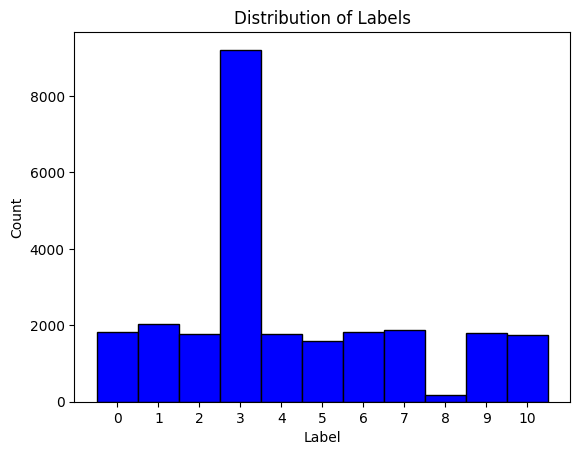

Label 0: 1826 (7.14%)
Label 1: 2034 (7.95%)
Label 2: 1775 (6.94%)
Label 3: 9213 (36.02%)
Label 4: 1766 (6.90%)
Label 5: 1591 (6.22%)
Label 6: 1813 (7.09%)
Label 7: 1865 (7.29%)
Label 8: 165 (0.65%)
Label 9: 1786 (6.98%)
Label 10: 1747 (6.83%)


In [93]:
plot_distribution(y_train)

we can see that the training data is still imbalanced with very many three's and few eight's

## Baseline models
In this section we will look at a couple of baseline models wich we will try to beat with a better performing model later.

### Majority class classifier
This classifier always predicts the majority label

In [94]:
#First lets create a list where we can store the results of each model and lets create a function to store the results

#Trained and evaluated models
trained_and_evaluated_models = [] 

#Function to store the results of a model
def store_results(model_name, y_pred, accuracy_score):
    result = {
        'model_name': model_name,
        'y_pred': y_pred,
        'accuracy_score': accuracy_score
    }
    trained_and_evaluated_models.append(result)

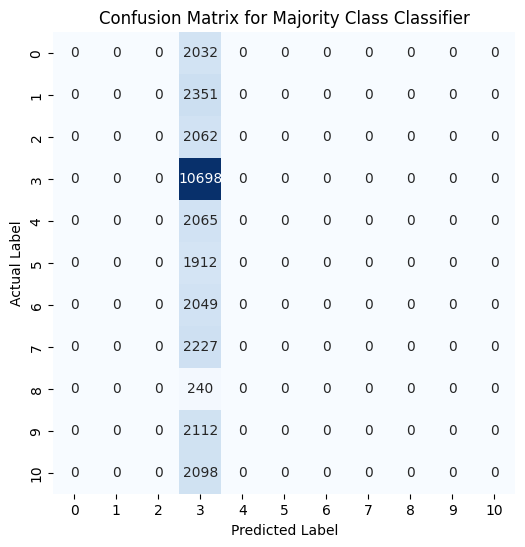

Accuracy:  0.35843999195872145


In [95]:
#Majority class classifier
y_pred = np.full(y_val.shape, np.argmax(np.bincount(y_train)))

#Function to plot a confusion matrix
def plot_confusion_matrix(y_val, y_pred, title):
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

#Plot the confusion matrix for the majority class classifier
plot_confusion_matrix(y_val, y_pred, 'Confusion Matrix for Majority Class Classifier')

#Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)

#Print accuracy
print("Accuracy: ", accuracy)

#Store the results of the majority class classifier
store_results('Majority Class Classifier', y_pred, accuracy)


We see that we get an accuracy of 0.3584 which is as expected after looking at the label distribution from earlier. This is not a very good accuracy.

### Random label classifier
This classifier will predic a random label each time

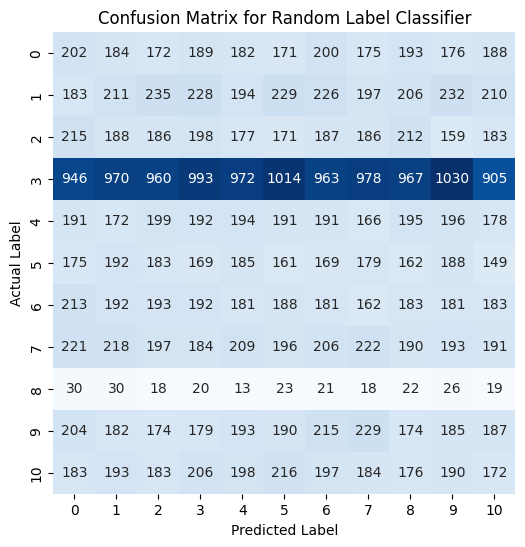

Accuracy:  0.09143603833009449


In [96]:
#Random label classifier

#Set seed for reproducibility
np.random.seed(42)
y_pred = np.random.randint(0, 11, y_val.shape)

#Plot the confusion matrix for the random label classifier
plot_confusion_matrix(y_val, y_pred, 'Confusion Matrix for Random Label Classifier')

#Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)

#Print the accuracy
print("Accuracy: ", accuracy)

#Store the results of the random label classifier
store_results('Random Label Classifier', y_pred, accuracy)

We can see that we got an even worse accuracy of only 0.0914. After looking at theese baseline models we know we should at least try to get a better accuracy than 0.3584.

## Random forest classifier

In [98]:
#Pipleline to train and test the model, then store the results
def train_and_test(model, model_name, X_train, y_train, X_val, y_val):
    #Reshape the data to be 2D
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)

    #Train the model
    model.fit(X_train, y_train)

    #Make predictions on the validation set
    y_pred = model.predict(X_val)

    #Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)

    #Store the results
    store_results(model_name, y_pred, accuracy)

#Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_test(rfc, 'Random Forest Classifier', X_train, y_train, X_val, y_val)

#TODO kildereferanse
https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
https://towardsdatascience.com/8-metrics-to-measure-classification-performance-984d9d7fd7aa

In [99]:
trained_and_evaluated_models[-1]['accuracy_score']

0.8786101990216444